# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

  ### Загрузка необходимых библиотек и инструментов.

In [15]:
!pip install pymystem3 -q
!pip install catboost -q 

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import os
from pymystem3 import Mystem
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     GridSearchCV, 
                                     StratifiedShuffleSplit, 
                                     TimeSeriesSplit,
                                     ParameterGrid)

# Модели машинного обучения 
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression, 
                                  Ridge,
                                  Lasso,
                                  ElasticNet)

from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
#from sklearn.tree import DecisionTreeClassifier
#from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, mean_squared_error, f1_score #, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import warnings
#warnings.filterwarnings('ignore')

In [17]:
state = np.random.seed(12345)

### Загрузка данных

In [18]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, parse_dates=[0])
else:
    print('Something is wrong')

In [19]:
def get_data_info(data):
    display(data.head(5))
    display(data.info())
    display(data.isna().sum())
#    display(data.describe(include='all'))

In [20]:
get_data_info(data)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  object
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


None

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Данные загружены. Пропусков и явных аномалий в данных нет.

### Вывод:

В данных содержится 159292 объекта без пропусков и 3 признака. 
- Признак 'text' содержит исходные тексты твитов на английском языке, является не целевым и будет использован в обучении и предсказании. 
- Признак 'toxic'  содержит данные по классификации текстов и явялется целевым.
Содержит только 0 и 1, но, при этом, имеет тип данных int64. Его следует оптимизировать до uint8.
Классы признака несбалансированны  многократным перевесом в пользу класса 0. Этот файкт требуется учесть при делении датафрейма на обучающие и тестовые выборки.
- Признак 'Unnamed: 0' не содержит ценной для обучения информации.

##  Обработка данных

Присутствует столбец 'Unnamed: 0' повторяющий индексацию, избавимся от него.

In [21]:
data = data.drop(['Unnamed: 0'], axis=1)

Целевой признак в столбце "toxic" является категоральным. Посмотрим на распределение классов в нем.

0    143106
1     16186
Name: toxic, dtype: int64


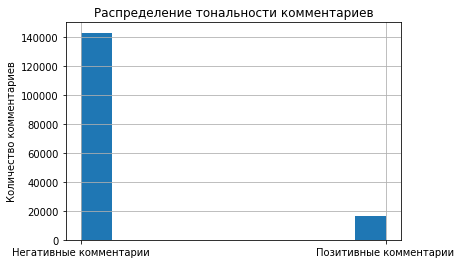

In [22]:
print(data['toxic'].value_counts())

data['toxic'].hist()
plt.title('Распределение тональности комментариев')
plt.ylabel('Количество комментариев')
plt.xticks([0,1],['Негативные комментарии','Позитивные комментарии'], rotation = 0)
plt.show()

Классы определенно несбалансированы. Нужно избавиться от дисбаланса данных, очистить и лимитизировать текст.

Воспользуемся для этого функцией.

In [23]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    """ Функуия очистки текста 
    (перевод в нижний регистр,
    удаление знаков препинания и символов, 
    стемминг и  лемматизация """
    
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Токенизация (преобразование из строки в список)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Стемминг (удаление -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Лемматизация (преобразование слова в корневое слово)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## возврат к строке из списка
    text = " ".join(lst_text)
    return text


lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [24]:
# применим написанную функцию ко всему набору данных и сохраним результат в новом столбце с именем «text_clean»
# чтобы мы могли работать с необработанным корпусом или с предварительно обработанным текстом.

data["text_clean"] = data["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

data.head()

,text,toxic,text_clean
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,daww match background colour im seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",0,cant make real suggestion improvement wondered...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page thats


Супер! Текст исправлен и готов к дальнейшей работе.

Разделим признаки для обучения и тестирования моделей. Выделим целевой признак.

In [25]:
# Стратифицируем train/val/test
strat = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

X = data['text_clean']
y = data['toxic']

for train_index, test_index in strat.split(X, y):
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]


In [26]:
# Создадим матрицу TF-IDF
# Обучим TfidfVectorizer на train, трансформируем test
vectorizer = TfidfVectorizer(stop_words=lst_stopwords)
X_train = vectorizer.fit_transform(X_train)


X_test = vectorizer.transform(X_test)

In [27]:
print("Обучающая выборка: ", X_train.shape, y_train.shape)
print("Тестовый набор: ", X_test.shape, y_test.shape)

Обучающая выборка:  (111504, 186816) (111504,)
Тестовый набор:  (47788, 186816) (47788,)


### Вывод

Данные очищены и подготовлены к построению моделей.
Бли проведены следущие манипуляции:
- удаление лишних данных,
- перевод текста в нижний регистр,
- удаление знаков препинания и символов, 
- стемминг и лемматизация текста,
- выделен целевой признак, дана оценка распределения классов в нем,
- выделены обучающая и тестовая выборки,
- проведен TF-IDF.

## Обучение

**Logistic Regression**

Возьмем в качестве baseline модель LogisticRegression небольшим каличеством гиперпараметров.

In [ ]:
model_lr_b = LogisticRegression(max_iter=1000, class_weight='balanced')
model_lr_b.fit(X_train, y_train)
# Предскажем на valid
y_train_pred_lr = model_lr_b.predict(X_train)

# Рассчитаем F1
f1_lr_b = f1_score(y_train, y_train_pred_lr)
print('F1 score: ', f1_lr)

F1 score:  0.7364228819695872

Довольно неплохой результат, но можно лучше. Подберем гиперпараметры.

In [ ]:
# сетка параметров
params = [{'penalty': ['l1', 'l2']
           , 'random_state': [12345] # default 1.0
           , 'C': np.arange(0.001, 6, 1) # default 5
           , 'max_iter': np.arange(100, 1000, 100)
           , 'solver': ['liblinear']
            #'regressor__C': np.arange(0.001, 10, 1) # default 5
           #, 'regressor__max_iter': np.arange(0, 210, 20)
          }]

model_lr = LogisticRegression()

# функционал ошибки
f1 = make_scorer(f1_score, average='micro')
    
# подбираем параметры
grid_lr = GridSearchCV(model_lr, param_grid=params, n_jobs=-1, cv=5, 
                         scoring=f1, verbose=True, error_score='raise')
grid_lr.fit(X_train, y_train)
    
#Посмотрим наилучшие подобранные параметры
print('')
print('Параметры лучшей модели:', grid_lr.best_params_)
print('Значение лучшей метрики качества:', grid_lr.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Параметры лучшей модели: {'C': 3.0009999999999994, 'max_iter': 100, 'penalty': 'l1', 'random_state': 12345, 'solver': 'liblinear'}
Значение лучшей метрики качества: 0.9593915919634401
    
Метрика качества стремится к 1. LogisticRegression явно переобучилась на данной задаче. Такой результат тяжело будет перебить, но на тестировочном датасете она покажет результаты явно ниже.

**CatBoostClassifier**

In [ ]:
# сетка параметров
params = [{'learning_rate': [0.2, 0.4]
           ,'depth': [5, 10, 15]
           ,'l2_leaf_reg': [1, 3, 5]
           ,'iterations': [200, 500, 1000]
           ,'border_count': [32, 64, 128, 254]
           ,'auto_class_weights': ['Balanced', 'SqrtBalanced']
          }]

model_cbr = CatBoostClassifier(random_state=state,verbose=50)

# функционал ошибки
f1 = make_scorer(f1_score, average='micro')
    
# подбираем параметры
grid_cbr = GridSearchCV(model_cbr, param_grid=params, n_jobs=-1, cv=5, 
                         scoring=f1, verbose=True, error_score='raise')
grid_cbr.fit(X_train, y_train)
    
#Посмотрим наилучшие подобранные параметры
print('')
print('Параметры лучшей модели:', grid_cbr.best_params_)
print('Значение лучшей метрики качества:', grid_cbr.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Лучшие гиперпараметры: {'auto_class_weights': 'SqrtBalanced', 'iterations': 1000, 'learning_rate': 0.2, 'loss_function': 'Logloss'}
F1 score:  0.7833405265429435

### Вывод

Были протестированы на обучающей выборке две модели машинного обучения и подобраны гиперпараметры к ним:

- LogisticRegression 
F1 = 0.9594, параметры модели: {'C': 3.0009999999999994, 'max_iter': 100, 'penalty': 'l1', 'random_state': 12345, 'solver': 'liblinear'}

- CatBoostClassifier
F1 = 0.7833, параметры модели: {'auto_class_weights': 'SqrtBalanced', 'iterations': 1000, 'learning_rate': 0.2, 'loss_function': 'Logloss'}
    
Обе модели построены со значением метрики качества F1 не меньше 0.75, но модель LogisticRegression показала явное переобучение . Протестируем на тестовом датасете CatBoostClassifier.

## Тестирование модели

 Лучшая модель  
 CatBoostClassifier(auto_class_weights='SqrtBalanced', iterations=1000, learning_rate=0.2, loss_function='Logloss')


In [ ]:
final_pred = grid_cat.predict(X_test)
f1 = f1_score(y_test, final_pred)
print('F1 score: ', f1)

F1 score:  0.7800624394445043

## Вывод


В ходе работы над проектом было сделано:

- подготовленны данные обучения на моделях,
- данные сбалансированны и поделены на обучающую и тестовою выборку,
- обучены модели с наилучшими показателями гиперпараметров,
- выбрана лучшая модель по параметру качества на валидационной выборке,
- лучшая модель протестированна на тестовых данных.

В проекте были иследованны две модели машинного обучения : LogisticRegression и CatBoostClassifier. Обе модели отлично справились с задачей на обучающем датасете. LogisticRegression превзошла всякие ожидания набрав F1 = 0.9594, но показатели метри качества так близко приближающиеся к 1 свидетельствуют о переобучении модели.

На тестовом датасете работал CatBoostClassifier. Показатель метрики качества  - F1 = 0.78. 
F1-мера удовлетворяет условию, а значит цель проекта достигнута!